# Water Discriminator


It is possible to discriminate water by its Normalized Difference Water Index (NDWI). An index is computed by using a band of green and another one of the near IR. Then, a treshold is applied in order to discriminate water from anything else.

$$NDWI = \frac{Xgreen - Xnir}{Xgreen + Xnir}$$

For now, it is supposed a good threshold for this is 0.3.

Wikipedia suggests using 559 nm for the green band and 864 nm for the NIR one.

The 144 bands cover [380-1050] nm.

Thus, $$\frac{1050-380+1}{144}=671$$

$$\frac{671}{144}=4.6597\ \textbf{nm per (or between) band}$$

$$\frac{559-380+1}{4.6597}=\frac{180}{4.6597}=38.629\approx{39}$$

$$\frac{864-380+1}{4.6597}=\frac{485}{4.6597}=104.08395\approx{104}$$

Thereforce, the index of the green band is 39 and the one of the near IR is 104.

To be more accurate, let's do a mean of the 38 and 39th bands for the green and respectively the mean of the 104 and 105th for the NIR.


In [1]:
import numpy as np
from utils import Classes

In [2]:
hsi = np.load("data/hyperspectral.npy")
groundtruth = np.load("groundtruth/groundtruth.npy")

In [3]:
green = (hsi[:, :, 38] + hsi[:, :, 39]) / 2
nir = (hsi[:, :, 104] + hsi[:, :, 105]) / 2

In [4]:
mask = (green != 0.0) | (nir != 0.0)
indexes = np.where(mask)
ndwi = (green[mask] - nir[mask]) / (green[mask] + nir[mask])

In [5]:
imgmask = np.zeros(hsi.shape[:-1])
water_idx = np.where(ndwi >= 0.5)
rr = indexes[0][water_idx]
cc = indexes[1][water_idx]
imgmask[rr, cc] = 1

### Color Map

In [6]:
from matplotlib.colors import ListedColormap

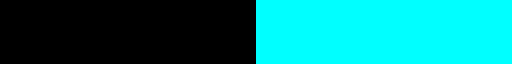

In [7]:
cmap = ListedColormap(np.array([[[0.0, 0.0, 0.0]], [[0.0, 1.0, 1.0]]]))
cmap

### Display

In [8]:
import matplotlib.pyplot as plt 

In [9]:
def display(img, cmap):
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap=cmap)

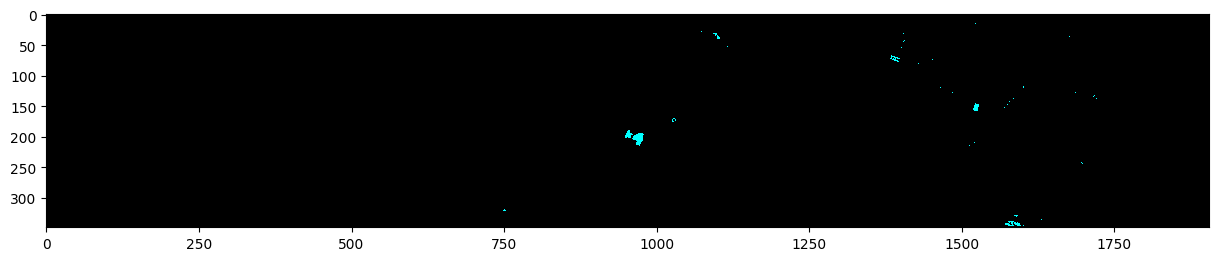

In [10]:
display(imgmask, cmap)

### Denoise

In [11]:
imgmask[:, 1250:] = 0  # TODO, when shadow problem solved, remove

In [12]:
from scipy.ndimage import median_filter

In [13]:
imgmask = median_filter(imgmask, size=3)

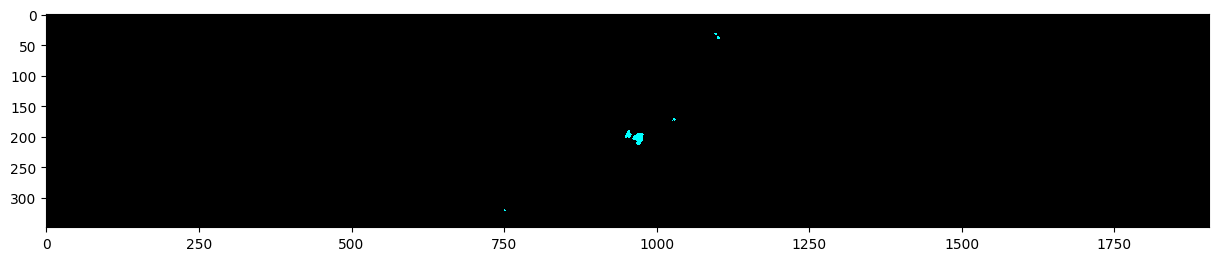

In [14]:
display(imgmask, cmap)

### Put in one function

In [15]:
from scipy.ndimage import median_filter


def water_discriminate(hsi, ndwi_threshold=0.5):
    green = (hsi[:, :, 38] + hsi[:, :, 39]) / 2
    nir = (hsi[:, :, 104] + hsi[:, :, 105]) / 2
    mask = np.where((green != 0.0) | (nir != 0.0))
    ndwi = (green[mask] - nir[mask]) / (green[mask] + nir[mask])
    imgmask = np.zeros(hsi.shape[:-1])
    water_idx = np.where(ndwi >= ndwi_threshold)
    rr, cc = indexes[0][water_idx], indexes[1][water_idx]
    imgmask[rr, cc] = 1
    imgmask = median_filter(imgmask, size=3)
    imgmask[:, 1250:] = 0  # TODO, remove after shadow problem solved
    return imgmask

### Test coincidence with groundtruth

In [16]:
def score_water(groundtruth, y_pred):
    water_mask = groundtruth == Classes.WATER
    water_mask_pred = y_pred[water_mask] != Classes.UNKNOWN
    return np.sum(water_mask_pred) / np.sum(water_mask)

In [17]:
score_water(groundtruth, water_discriminate(hsi))

0.7472527472527473

### Search for best threshold

Here we want not only the best score with respect to the groundtruth but also the closest coverage to grountruth.

In [18]:
from scipy.spatial.distance import directed_hausdorff

In [19]:
def best_treshold_get(hsi, groundtruth, start=0.0, end=1.0, offset=0.01, debug=False):
    best_score = float("-inf")
    best_threshold = -1.0
    best_coverage = float("+inf")
    gcoverage = np.argwhere(groundtruth == Classes.WATER)
    while start < end:
        y_pred = water_discriminate(hsi, start)
        coverage = np.argwhere(y_pred != Classes.UNKNOWN)
        score = score_water(groundtruth, y_pred)
        p2g = directed_hausdorff(coverage, gcoverage)
        g2p = directed_hausdorff(gcoverage, coverage)
        hdist = max(p2g, g2p)[0]
        if debug:
            print(f"{start=}, {score=}, {hdist=}")
        if hdist < best_coverage and score >= best_score * 0.95:
            best_score = score
            best_threshold = start
            best_coverage = hdist
        start += offset
    return best_threshold, best_score

In [20]:
best_threshold, best_score = best_treshold_get(hsi, groundtruth)
best_threshold, best_score

(0.46000000000000024, 0.7637362637362637)

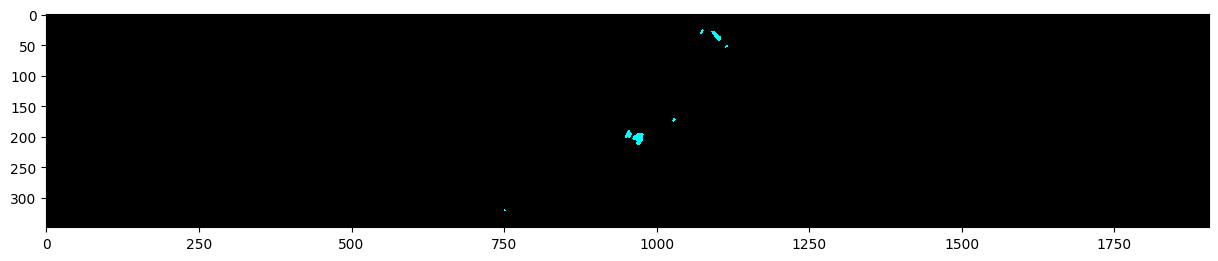

In [21]:
img = water_discriminate(hsi, 0.46)
display(img, cmap)

A threshold of 0.46 seems ok but by comparing with the original image it seems to contain too much water in the upper right corner.

Let's increase it slightly.

0.7472527472527473


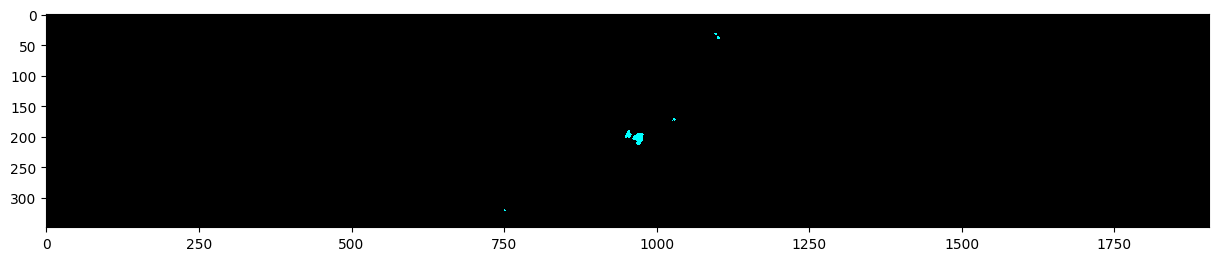

In [22]:
img = water_discriminate(hsi, 0.5)
score = score_water(groundtruth, img)
print(score)
display(img, cmap)

75% coincidence with grountruth is not bad but there is room for improvement.

Let's find out the missclassifications (the pixels groundtruth says it is water and our solution does not).

In [23]:
img_bis = img.copy()
img_bis[(groundtruth == Classes.WATER) & (img_bis == Classes.UNKNOWN)] = 2

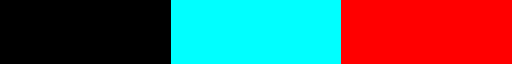

In [24]:
cmap_bis = ListedColormap(
    np.array([[[0.0, 0.0, 0.0]], [[0.0, 1.0, 1.0]], [[1.0, 0.0, 0.0]]])
)
cmap_bis

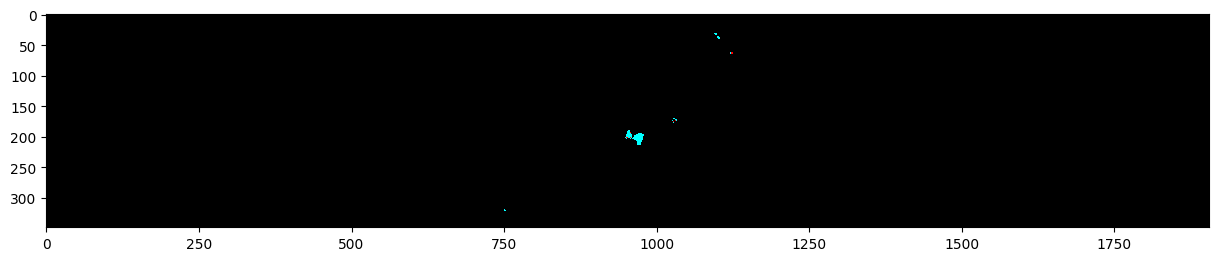

In [25]:
display(img_bis, cmap_bis)